In [1]:
import matplotlib.pyplot as plt
import os

import pyopia.classify
import pyopia.process
import pyopia.statistics
import pyopia.pipeline
import pyopia.instrument.silcam
import pyopia.io
import pyopia.tests.testdata
import pyopia.plotting

In [2]:
filename = pyopia.tests.testdata.get_example_silc_image(os.getcwd())

In [3]:
settings = {'general': {'raw_files': None,
                        'pixel_size': 24},
            'steps': {'note': 'non-standard pipeline.'}
           }

In [4]:
MyPipeline = pyopia.pipeline.Pipeline(settings=settings, initial_steps='')

Initialising pipeline
raw_files: None
Pipeline ready with these data:  ['cl', 'settings', 'raw_files']


In [5]:
model_path = pyopia.tests.testdata.get_example_model(os.getcwd())

MyPipeline.settings['steps'].update({'classifier':
                                       {'pipeline_class': 'pyopia.classify.Classify',
                                       'model_path': model_path}
                                    })
MyPipeline.run_step('classifier')
# This is the same as running:
# MyPipeline.data['cl'] = pyopia.classify.Classify(model_path=model_path)
# Note: the classifier step is special in that it's output is specifically data['cl'], rather than other new keys in data

MyPipeline.data

Classify  ready with: {'model_path': 'keras_model.h5'}  and data dict_keys(['cl', 'settings', 'raw_files'])


{'cl': <pyopia.classify.Classify at 0x113c5e020>,
 'settings': {'general': {'raw_files': None, 'pixel_size': 24},
  'steps': {'note': 'non-standard pipeline.',
   'classifier': {'pipeline_class': 'pyopia.classify.Classify',
    'model_path': 'keras_model.h5'}}},
 'raw_files': None}

SilCamLoad  ready with: {}  and data dict_keys(['cl', 'settings', 'raw_files', 'filename'])


Text(0.5, 1.0, 'imraw')

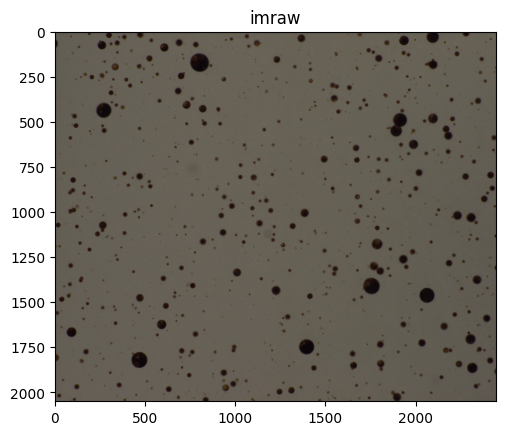

In [6]:
# since we are not going to be using MyPipeline.run(filename) here, we need to manually add filename into the pipeline data:
MyPipeline.data['filename'] = filename

MyPipeline.settings['steps'].update({'load':
                                       {'pipeline_class': 'pyopia.instrument.silcam.SilCamLoad'}
                                    })
MyPipeline.run_step('load')

# This is the same as running:
#SilCamLoad = pyopia.instrument.silcam.SilCamLoad()
#MyPipeline.data = SilCamLoad(MyPipeline.data)

plt.imshow(MyPipeline.data['imraw'][:,:,:]/255)
plt.title('imraw')

ImagePrep  ready with: {'image_level': 'imraw'}  and data dict_keys(['cl', 'settings', 'raw_files', 'filename', 'timestamp', 'imraw'])


Text(0.5, 1.0, 'imc')

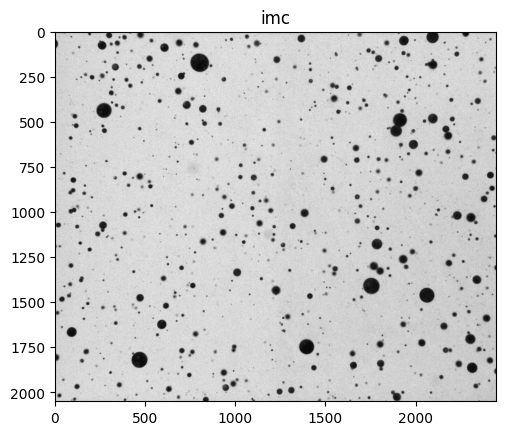

In [7]:
MyPipeline.settings['steps'].update({'imageprep':
                                       {'pipeline_class': 'pyopia.instrument.silcam.ImagePrep',
                                        'image_level': 'imraw'}
                                    })
MyPipeline.run_step('imageprep')
# This is the same as running:
# ImagePrep = pyopia.instrument.silcam.ImagePrep(image_level='imraw')
# MyPipeline.data = ImagePrep(MyPipeline.data)

plt.imshow(MyPipeline.data['imc'], cmap='grey')
plt.title('imc')

Segment  ready with: {'threshold': 0.85}  and data dict_keys(['cl', 'settings', 'raw_files', 'filename', 'timestamp', 'imraw', 'imref', 'imc'])
segment
clean


Text(0.5, 1.0, 'imbw')

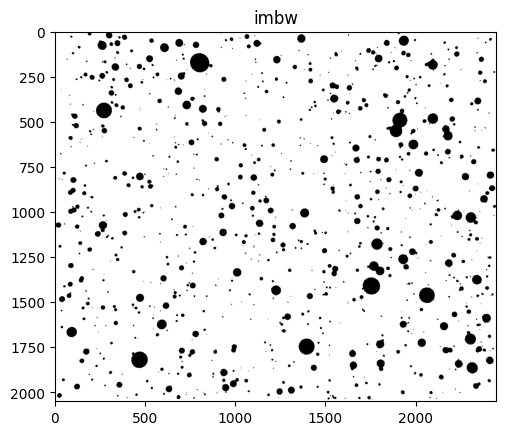

In [8]:
MyPipeline.settings['steps'].update({'segmentation':
                            {'pipeline_class': 'pyopia.process.Segment',
                            'threshold': 0.85}}
                        )

MyPipeline.run_step('segmentation')

# This is the same as running:
# Segment = pyopia.process.Segment(threshold=settings['steps']['segmentation']['threshold'])
# data = Segment(data)
plt.imshow(~MyPipeline.data['imbw'], cmap='grey')
plt.title('imbw')

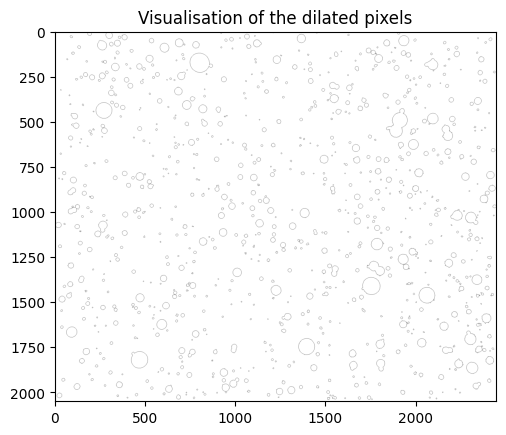

In [9]:
# Example dilation of everything

# define a step for inserting into the metadata.
MyPipeline.settings['steps'].update(
                    {'dilation':
                        {'custom step': 'dilate segmented image by 1 pixel'}}
                )

# run our custom code
import skimage

imbw_original = MyPipeline.data['imbw']
imbw_dilated = skimage.morphology.binary_dilation(imbw_original)

plt.imshow(imbw_original.astype(int) - imbw_dilated.astype(int), cmap='grey')
plt.title('Visualisation of the dilated pixels')

# redefine 'imbw', which is needed for the next step
MyPipeline.data['imbw'] = imbw_dilated

In [10]:
MyPipeline.settings['steps'].update({'statextract':
                                        {'pipeline_class': 'pyopia.process.CalculateStats'}}
                                    )

# This is the same as running:
# CalculateStats = pyopia.process.CalculateStats()
# data = CalculateStats(data)

MyPipeline.run_step('statextract')

CalculateStats  ready with: {}  and data dict_keys(['cl', 'settings', 'raw_files', 'filename', 'timestamp', 'imraw', 'imref', 'imc', 'imbw'])
statextract
24.8% saturation
measure
  853 particles found
WARNING. exportparticles temporarily modified for 2-d images without color!
EXTRACTING 853 IMAGES from 853


In [11]:
xstats = pyopia.io.make_xstats(MyPipeline.data['stats'], settings)
xstats

<xarray.Dataset>
Dimensions:                     (index: 853)
Coordinates:
  * index                       (index) int64 0 1 2 3 4 ... 848 849 850 851 852
    time                        (index) datetime64[ns] 2018-11-01T14:27:31.83...
Data variables: (12/17)
    major_axis_length           (index) float64 7.811 17.56 23.1 ... 8.056 7.524
    minor_axis_length           (index) float64 4.533 14.91 ... 6.461 4.763
    equivalent_diameter         (index) float64 5.863 16.12 ... 7.225 5.971
    minr                        (index) float64 2.0 2.0 ... 2.032e+03 2.036e+03
    minc                        (index) float64 76.0 1.895e+03 ... 1.753e+03
    maxr                        (index) float64 9.0 19.0 ... 2.04e+03 2.044e+03
    ...                          ...
    probability_copepod         (index) float64 0.004393 2.323e-06 ... 0.002888
    probability_diatom_chain    (index) float64 0.003636 2.031e-07 ... 0.003968
    probability_oily_gas        (index) float64 0.06183 0.008561 ... 0.03824
    export name                 (index) object 'D20181101T142731.838206-PN0' ...
    timestamp                   (index) datetime64[ns] 2018-11-01T14:27:31.83...
    saturation                  (index) float64 24.77 24.77 ... 24.77 24.77
Attributes:
    steps:           [general]\npixel_size = 24\n\n[steps]\nnote = "non-stand...
    Modified:        2024-08-06 11:38:44.992418
    PyOpia version:  1.1.3

In [12]:
# @todo Example plot bounding boxes